# A BERT-Based Transfer Learning Approach for Hate Speech Detection in Online Social Media [link](https://arxiv.org/pdf/1910.12574.pdf)

dataset used \\
https://github.com/zeeraktalat/hatespeech \\
https://huggingface.co/datasets/hate_speech_offensive

library need to be installed

In [1]:
!pip install transformers emoji torchmetrics  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.2 MB/s eta 0:00:00


# import

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import gc
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertModel, BertTokenizer, AdamW, AutoModel, AutoModelForMaskedLM, AutoTokenizer, DistilBertTokenizer, DistilBertModel, BartTokenizer, BartModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics import *
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim import AdamW

# Model

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class BERT_Arch(nn.Module):
    def __init__(self, modelName, num_class):
        super(BERT_Arch, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-uncased")
        for param in self.model.parameters():
            param.requires_grad = False
        self.conv = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=(3, 768), padding=(1, 0))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(3, 1), stride=(1, 1))
        self.dropout = nn.Dropout(0.1)
        self.batch_norm = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.1)
        self.fc = nn.Linear(1984, num_class)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        all_layers = self.model(sent_id, attention_mask=mask, output_hidden_states=True)
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers[2]]), 0), 0, 1)
        x = self.dropout(x)
        x = self.conv(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(self.dropout(x))
        return self.softmax(x)

# Preprocessing

In [5]:
def load_and_process(dataset, column_to_drop, modelName, text, label):
    data, labels = read_dataset(dataset, column_to_drop, text, label)
    num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels, modelName)
    return input_ids, attention_masks, labels,  data, labels


def read_dataset(file, column_to_drop, text, label):
    data = pd.read_csv(file)
    data = data.drop(column_to_drop, axis=1)
    return data[text].tolist(), data[label]


def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']
    # for each sentence
    for value in values:
        # Remove dots
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.EMOJI_DATA.keys():
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text).strip()
        new_values.append(text)
    return new_values




def data_process(data, labels, modelName):
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = tokenizer.__call__(sentence, max_length=64,
                                          padding='max_length', pad_to_max_length=True,
                                          truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

# utils

In [6]:
def progress_bar(i, total, accuracy, loss, batch_size):
    step = i+1
    percent = "{0:.2f}".format(100 * (step / float(total)))
    lossp = "{0:.4f}".format(loss)
    accuracy = "{0:.4f}".format(accuracy)
    filledLength = int(100 * step // total)
    bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
    print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={accuracy}', end='')

def init_batch(batch):
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    del batch
    gc.collect()
    torch.cuda.empty_cache()
    return sent_id, mask, labels

def to_tensor(dict_text, label):
    seq = torch.tensor(np.stack(dict_text['input_ids'].values))
    mask = torch.tensor(np.stack(dict_text['attention_masks'].values))
    y = torch.tensor(label)
    return seq, mask, y

In [7]:
def predict(model, sent_id, mask, labels, cross_entropy):
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    return preds, loss

def output_model(total_loss, train_dataloader, batch_size, total_preds):
    avg_loss = total_loss / (len(train_dataloader)*batch_size)
    total_preds = np.stack(total_preds[0].detach().cpu().numpy(), axis=0)
    return avg_loss, total_preds

In [12]:
def train(model, train_dataloader, optimizer, cross_entropy, scheduler, batch_size):
    print("\n\n Training...")
    model.train()
    total_loss, total_accuracy = 0, 0
    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):
        progress_bar(i, total, total_accuracy / (i + 1), total_loss / (i + 1), batch_size)
        sent_id, mask, labels = init_batch(batch)
        # clear previously calculated gradients
        model.zero_grad()
        # compute the loss between actual and predicted value
        preds, loss = predict(model, sent_id, mask, labels, cross_entropy)
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        before_lr = optimizer.param_groups[0]["lr"]
        # append the model predictions
        scheduler.step()
        if i % 30 == 0:
            after_lr = optimizer.param_groups[0]["lr"]
            print("\nEpoch %d: SGD lr %.4f -> %.4f" % (i, before_lr, after_lr))
        total_loss += loss.mean().item()
        total_accuracy += acc(preds.argmax(axis=1), labels).mean().item()

    return total_loss / total, total_accuracy / total

# function for evaluating the model
def evaluate(val_dataloader, cross_entropy, batch_size):
    print("\n\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy, total_preds = 0, 0, []
    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        progress_bar(i, total, total_accuracy / (i + 1), total_loss / (i + 1), batch_size)
        sent_id, mask, labels = init_batch(batch)
        # deactivate autograd
        with torch.no_grad():
            preds, loss = predict(model, sent_id, mask, labels, cross_entropy)
            total_loss += loss.mean().item()
            total_accuracy += acc(preds.argmax(axis=1), labels).mean().item()
    return total_loss / total, total_accuracy / total

def predict_and_print_performance(model, batch_size, accuracy_function):
    j = 0
    preds_ = []
    total_loss, total_accuracy, total_preds = 0, 0, []
    test_y = []
    total = len(test_dataloader)
    for i, batch in enumerate(test_dataloader):
        test_y.extend(list(batch[2].numpy()))
        progress_bar(i, total, total_accuracy / (i + 1), total_loss / (i + 1), batch_size)
        sent_id, mask, labels = init_batch(batch)
        # deactivate autograd
        with torch.no_grad():
            preds, loss = predict(model, sent_id, mask, labels, cross_entropy)
            total_loss += loss.mean().item()
            total_accuracy += acc(preds.argmax(axis=1), labels).mean().item()
            preds_.extend(list(preds.argmax(axis=1).detach().cpu().numpy()))


    print("\nPerformance:")
    print('Classification Report')
    print(classification_report(test_y, preds_))
    print("Accuracy: " + str(accuracy_score(test_y, preds_)))

In [9]:
def to_dataset(X, y, batch_size):
    data, mask, y = to_tensor(X, y)
    # wrap tensors
    data = TensorDataset(data, mask, y)
    # sampler for sampling the data during training
    train_sampler = RandomSampler(data)
    # dataLoader for train set
    dataloader = DataLoader(data, sampler=train_sampler, batch_size=batch_size)
    return dataloader

In [10]:
def split_in_train_val_test(df, labels, batch_size):
    train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
                             random_state=1234, test_size=0.2, stratify=labels)

    val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=1234, test_size=0.5, stratify=temp_labels)

    del temp_text
    gc.collect()
    torch.cuda.empty_cache()
    train_dataloader = to_dataset(train_text, train_labels, batch_size)
    val_dataloader = to_dataset(val_text, val_labels, batch_size)
    test_dataloader = to_dataset(test_text, test_labels, batch_size)
    return train_dataloader, val_dataloader, test_dataloader

In [23]:
def init_file(num_classes, type_task, path_file, column_to_drop, text_column_name, column_label_name, batch_size):
    acc = Accuracy('multiclass', num_classes=num_classes).to(device)
    input_ids, attention_masks, labels, data, labels = load_and_process(path_file, column_to_drop, "bert-base-uncased", text_column_name, column_label_name)
    df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])
    train_dataloader, val_dataloader, test_dataloader = split_in_train_val_test(df, labels, batch_size)
    gc.collect()
    torch.cuda.empty_cache()
    # pass the pre-trained BERT to our define architecture
    model = BERT_Arch("bert-base-uncased", num_classes)
    # push the model to GPU
    model = model.to(device)
    return train_dataloader, val_dataloader, test_dataloader, acc, model

In [13]:
def train_and_validate(train_dataloader, val_dataloader,  model, learning_rate, epochs, cross_entropy, batch_size ):
    optimizer = AdamW(model.parameters(), lr= learning_rate)
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=len(train_dataloader) * epochs)
    current = 1
    #cross_entropy = nn.NLLLoss()

    best_valid_loss = float('inf')
    while current <= epochs:
        print(f'\nEpoch {current} / {epochs}:')

        # train model
        train_loss, _ = train(model, train_dataloader, optimizer, cross_entropy, scheduler, batch_size)

        # evaluate model
        valid_loss, _ = evaluate(val_dataloader, cross_entropy, batch_size)

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss

        print(f'\n\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

        current = current + 1
    #return model

# Datasets

## Automated Hate Speech Detection Dataset

In [ ]:
file_path = "/content/drive/MyDrive/Data science/NLP/dataset/hate_speech_offensiveWithHatespeech/labeled_data.csv"
column_to_drop = ['count', 'hate_speech', 'offensive_language', 'neither']
train_dataloader, val_dataloader, test_dataloader, acc, model = init_file(num_classes=3, type_task='multiclass', path_file= file_path, column_to_drop=column_to_drop, \
          text_column_name='tweet', column_label_name="class", batch_size=32)

### Train

In [ ]:
weights = torch.tensor([2., 1., 1.])
weight=weights.to(device)
cross_entropy = nn.CrossEntropyLoss(weight=weight)
train_and_validate(train_dataloader, val_dataloader,  model, learning_rate = 2e-5 , epochs = 1, cross_entropy= cross_entropy, batch_size=32)


Epoch 1 / 1:


 Training...
Batch 1/620 |>...................................................................................................| 0.16% complete, loss=0.0000, accuracy=0.0000
Epoch 0: SGD lr 0.0000 -> 0.0000
Batch 31/620 |█████>..............................................................................................| 5.00% complete, loss=0.2613, accuracy=0.9032
Epoch 30: SGD lr 0.0000 -> 0.0000
Batch 61/620 |█████████>..........................................................................................| 9.84% complete, loss=0.2574, accuracy=0.9185
Epoch 60: SGD lr 0.0000 -> 0.0000
Batch 91/620 |██████████████>.....................................................................................| 14.68% complete, loss=0.2537, accuracy=0.9217
Epoch 90: SGD lr 0.0000 -> 0.0000
Batch 121/620 |███████████████████>................................................................................| 19.52% complete, loss=0.2486, accuracy=0.9261
Epoch 120: SGD lr 0.0000 -> 0

### Test

In [ ]:
predict_and_print_performance(model, batch_size=32, accuracy_function=acc)

Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.3383, accuracy=0.8946
Performance:
Classification Report
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       143
           1       0.93      0.95      0.94      1919
           2       0.85      0.88      0.87       417

    accuracy                           0.91      2479
   macro avg       0.78      0.73      0.75      2479
weighted avg       0.90      0.91      0.90      2479

Accuracy: 0.9068172650262203


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Data science/NLP/mina/model_saved_2")

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Data science/NLP/mina/model_saved_2"))

<All keys matched successfully>

Risultati replicati (Quasi)

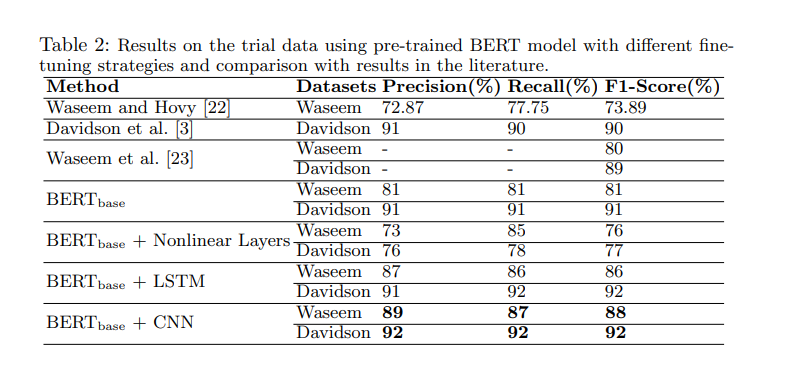

## Wiki Toxic Dataset

In [ ]:
# I adapt the dataset according to my criteria, like the name of the columns
df2 = pd.read_csv("/content/drive/MyDrive/Data science/NLP/Alex/wiki_toxic.csv")
df2 = df2.rename(columns={'comment_text': 'tweet', 'label': 'class'})
df2 = df2[~df2.tweet.isna()]
df2.to_csv("/content/drive/MyDrive/Data science/NLP/Alex/wiki_toxic.csv", encoding='utf-8', index=False)

In [24]:
file_path = "/content/drive/MyDrive/Data science/NLP/Alex/wiki_toxic.csv"
column_to_drop = ['Unnamed: 0', 'id']
train_dataloader, val_dataloader, test_dataloader, acc, model = init_file(num_classes=2, type_task='multiclass', path_file= file_path, column_to_drop=column_to_drop, \
          text_column_name='tweet', column_label_name="class", batch_size=128)

### Train

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
train_and_validate(train_dataloader, val_dataloader,  model, learning_rate = 2e-5 , epochs = 1, cross_entropy= cross_entropy, batch_size=128)


Epoch 1 / 3:


 Training...
Batch 1/281 |>...................................................................................................| 0.36% complete, loss=0.0000, accuracy=0.0000
Epoch 0: SGD lr 0.0001 -> 0.0001
Batch 31/281 |███████████>........................................................................................| 11.03% complete, loss=0.4898, accuracy=0.7210
Epoch 30: SGD lr 0.0001 -> 0.0001
Batch 61/281 |█████████████████████>..............................................................................| 21.71% complete, loss=0.4354, accuracy=0.7745
Epoch 60: SGD lr 0.0001 -> 0.0001
Batch 91/281 |████████████████████████████████>...................................................................| 32.38% complete, loss=0.4080, accuracy=0.7982
Epoch 90: SGD lr 0.0001 -> 0.0001
Batch 121/281 |███████████████████████████████████████████>........................................................| 43.06% complete, loss=0.3901, accuracy=0.8119
Epoch 120: SGD lr 0.0001 ->

### Test


In [28]:
predict_and_print_performance(model, batch_size=128, accuracy_function=acc)

Batch 36/36 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.2247, accuracy=0.8841
Performance:
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2247
           1       0.89      0.93      0.91      2247

    accuracy                           0.91      4494
   macro avg       0.91      0.91      0.91      4494
weighted avg       0.91      0.91      0.91      4494

Accuracy: 0.9094348019581664


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Data science/NLP/mina/Mina_model_Dataset_di_Alex_2")

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Data science/NLP/mina/Mina_model_Dataset_di_Alex_2"))

## SemEval-2019 Dataset

In [30]:
df2 = pd.read_csv("/content/drive/MyDrive/Data science/NLP/Ema/hateval2019/hateval2019_en_train.csv")
df3 = pd.read_csv("/content/drive/MyDrive/Data science/NLP/Ema/hateval2019/hateval2019_en_test.csv")
df4 = pd.read_csv("/content/drive/MyDrive/Data science/NLP/Ema/hateval2019/hateval2019_en_dev.csv")
result = pd.concat([df2, df3, df4])
result = result.rename(columns={'text': 'tweet', 'HS': 'class'})
result = result[~result.tweet.isna()]
result.to_csv("/content/drive/MyDrive/Data science/NLP/Ema/hateval2019_en_train2.csv", encoding='utf-8', index=False)

In [37]:
file_path = "/content/drive/MyDrive/Data science/NLP/Ema/hateval2019_en_train2.csv"
column_to_drop = ['TR', 'id', 'AG']
train_dataloader, val_dataloader, test_dataloader, acc, model = init_file(num_classes=2, type_task='multiclass', path_file= file_path, column_to_drop=column_to_drop, \
          text_column_name='tweet', column_label_name="class", batch_size=128)

### Train

In [38]:
cross_entropy = nn.CrossEntropyLoss()
train_and_validate(train_dataloader, val_dataloader,  model, learning_rate = 0.001 , epochs = 1, cross_entropy= cross_entropy, batch_size=128)


Epoch 1 / 1:


 Training...
Batch 1/82 |█>..................................................................................................| 1.22% complete, loss=0.0000, accuracy=0.0000
Epoch 0: SGD lr 0.0010 -> 0.0010
Batch 31/82 |█████████████████████████████████████>..............................................................| 37.80% complete, loss=0.7480, accuracy=0.5900
Epoch 30: SGD lr 0.0008 -> 0.0008
Batch 61/82 |██████████████████████████████████████████████████████████████████████████>.........................| 74.39% complete, loss=0.6657, accuracy=0.6419
Epoch 60: SGD lr 0.0006 -> 0.0006
Batch 82/82 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.6356, accuracy=0.6577

Evaluating...
Batch 11/11 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.4668, accuracy=0.6776

Training Loss: 0.642
Validation Loss: 0.526


### Test

In [39]:
predict_and_print_performance(model, batch_size=128, accuracy_function=acc)

Batch 11/11 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.4620, accuracy=0.6776
Performance:
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       753
           1       0.68      0.75      0.71       547

    accuracy                           0.75      1300
   macro avg       0.74      0.75      0.74      1300
weighted avg       0.75      0.75      0.75      1300

Accuracy: 0.7476923076923077
